In [1]:
# prompt: mount the drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/MAML-Pytorch-master/Experiment2/Data'

/content/drive/MyDrive/MAML-Pytorch-master/Experiment2/Data


In [3]:
%cd '/content/drive/MyDrive/MAML-Pytorch-master/Experiment2'

/content/drive/MyDrive/MAML-Pytorch-master/Experiment2


In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [5]:
import os
import csv

assigned_label = 0
train_root = 'Data/CSU_cattle_final/train'
test_root = 'Data/CSU_cattle_final/test'

# Get the list of cattle names (subdirectories)
train_cattle = next(os.walk(train_root))[1]
test_cattle = next(os.walk(test_root))[1]

# Writing training data
with open('cattle_train_data.csv', 'w', newline='') as csvfile:
    fields = ['ID', 'Path', 'Label']
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(fields)

    for cattle_name in train_cattle:
        for image in os.listdir(os.path.join(train_root, cattle_name)):
            label = assigned_label
            path = os.path.join(train_root, cattle_name, image)
            csvwriter.writerow([image, path, str(label)])
        assigned_label += 1

# Reset the label for test data
assigned_label = 0

# Writing test data
with open('cattle_test_data.csv', 'w', newline='') as csvfile:
    fields = ['ID', 'Path', 'Label']
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(fields)

    for cattle_name in test_cattle:
        for image in os.listdir(os.path.join(test_root, cattle_name)):
            label = assigned_label
            path = os.path.join(test_root, cattle_name, image)
            csvwriter.writerow([image, path, str(label)])
        assigned_label += 1


In [6]:
trainframe=pd.read_csv("cattle_train_data.csv")
testframe=pd.read_csv("cattle_test_data.csv")

In [7]:
trainframe.head(-1)

,ID,Path,Label
0,S183_3.JPG,Data/CSU_cattle_final/train/S183/S183_3.JPG,0
1,S183_4.JPG,Data/CSU_cattle_final/train/S183/S183_4.JPG,0
2,S183_1.JPG,Data/CSU_cattle_final/train/S183/S183_1.JPG,0
3,S183_2.JPG,Data/CSU_cattle_final/train/S183/S183_2.JPG,0
4,S183_5.JPG,Data/CSU_cattle_final/train/S183/S183_5.JPG,0
...,...,...,...
148,S78_9.JPG,Data/CSU_cattle_final/train/S78/S78_9.JPG,21
149,S78_3.JPG,Data/CSU_cattle_final/train/S78/S78_3.JPG,21
150,S78_4.JPG,Data/CSU_cattle_final/train/S78/S78_4.JPG,21
151,S78_5.JPG,Data/CSU_cattle_final/train/S78/S78_5.JPG,21


In [8]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
class Task(object):
  def __init__(self,all_classes,num_classes,num_instances):
    self.all_classes=all_classes
    self.num_classes=num_classes
    self.num_instances=num_instances
    self.train_roots=[]
    self.meta_roots=[]
    self.train_labels=[]
    self.meta_labels=[]
    samples_per_class=2
    sampled_classes=random.sample(all_classes,num_classes)
    label=0
    #labels=list(range(len(sampled_classes)))

    for c in sampled_classes:
      cframe=trainframe.iloc[(c*samples_per_class):((c+1)*samples_per_class)]
      cframe.reset_index(inplace=True,drop=True)
      paths=cframe["Path"]
      sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
      train_idxs=sample_idxs[:num_instances]
      meta_idxs=sample_idxs[num_instances:(num_instances*2)]
      for idx in train_idxs:
        self.train_roots.append(paths[idx])
        self.train_labels.append(label)
      for idx in meta_idxs:
        self.meta_roots.append(paths[idx])
        self.meta_labels.append(label)
      label+=1

class TestTask(object):
  def __init__(self,all_classes,num_classes,num_instances,num_test_instances):
    self.all_classes=all_classes
    self.num_classes=num_classes
    self.num_instances=num_instances
    self.num_test_instances=num_test_instances
    self.test_roots=[]
    self.train_roots=[]
    self.test_labels=[]
    self.train_labels=[]
    samples_per_class=2
    sampled_classes=random.sample(all_classes,num_classes)
    label=0
    #labels=list(range(len(sampled_classes)))

    for c in sampled_classes:
      #cframe=testframe.iloc[((c-964)*samples_per_class):(((c+1)-964)*samples_per_class)]
      cframe=testframe.iloc[((c-22)*samples_per_class):(((c+1)-22)*samples_per_class)]
      cframe.reset_index(inplace=True,drop=True)
      paths=cframe["Path"]
      sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
      train_idxs=sample_idxs[:num_instances]
      test_idxs=sample_idxs[num_instances:(num_instances+num_test_instances)]
      for idx in test_idxs:
        self.test_roots.append(paths[idx])
        self.test_labels.append(label)
      # for idx in meta_idxs:
      #   self.meta_roots.append(paths[idx])
      #   self.meta_labels.append(label)
      for idx in train_idxs:
        self.train_roots.append(paths[idx])
        self.train_labels.append(label)
      label+=1

In [10]:
class MiniSet(Dataset):
  def __init__(self,fileroots,labels,transform):
    self.fileroots=fileroots
    self.labels=labels
    self.transform=transform

  def __len__(self):
    return len(self.fileroots)

  def __getitem__(self,idx):
    img=Image.open(self.fileroots[idx])
    img=self.transform(img)
    return img,self.labels[idx]

In [11]:
transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
def get_loaders(task):
  loaders={}
  train_fileroots=task.train_roots
  train_labels=task.train_labels
  meta_fileroots=task.meta_roots
  meta_labels=task.meta_labels
  trainloader=DataLoader(MiniSet(train_fileroots,train_labels,transform),
                         batch_size=len(train_fileroots),shuffle=True)
  metaloader=DataLoader(MiniSet(meta_fileroots,meta_labels,transform),
                         batch_size=len(meta_fileroots),shuffle=True)
  #print((len(trainloader)))
  #print((len(metaloader)))
  loaders["train"]=trainloader
  loaders["meta"]=metaloader
  return loaders

def get_test_loaders(task):
  loaders={}
  test_fileroots=task.test_roots
  test_labels=task.test_labels
  train_fileroots=task.train_roots
  train_labels=task.train_labels
  testloader=DataLoader(MiniSet(test_fileroots,test_labels,transform),
                         batch_size=len(test_fileroots),shuffle=True)
  # metaloader=DataLoader(MiniSet(meta_fileroots,meta_labels,transform),
  #                        batch_size=len(meta_fileroots),shuffle=True)
  trainloader=DataLoader(MiniSet(train_fileroots,train_labels,transform),
                         batch_size=len(train_fileroots),shuffle=True)
  loaders["train"]=trainloader
  #loaders["meta"]=metaloader
  loaders["test"]=testloader
  return loaders

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze: Global Average Pooling
        b, c, _, _ = x.size()
        y = F.avg_pool2d(x, x.size(2)).view(b, c)
        # Excitation: Fully connected layers
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        # Scale the original input
        return x * y.expand_as(x)

class BaseNet(nn.Module):
    def __init__(self, num_classes):
        super(BaseNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 64, 3)),
            ('bn1', nn.BatchNorm2d(64, momentum=1, affine=True)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(2,2)),
            ('conv2', nn.Conv2d(64, 64, 3)),
            ('bn2', nn.BatchNorm2d(64, momentum=1, affine=True)),
            ('relu2', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(2,2)),
            ('conv3', nn.Conv2d(64, 64, 3)),
            ('bn3', nn.BatchNorm2d(64, momentum=1, affine=True)),
            ('relu3', nn.ReLU(inplace=True)),
            ('pool3', nn.MaxPool2d(2,2))
        ]))
        self.se = SEBlock(64)
        self.add_module('fc', nn.Linear(64, num_classes))

    def forward(self, x, weights=None):
        if weights is None:
            output = self.features(x)
            output = self.se(output)  # Apply SE block here
            output = output.view(-1, 64)
            output = self.fc(output)
        else:
            x = F.conv2d(x, weights['meta_learner.features.conv1.weight'], weights['meta_learner.features.conv1.bias'])
            x = F.batch_norm(x, weights['meta_learner.features.bn1.running_mean'],
                             weights['meta_learner.features.bn1.running_var'],
                             weights['meta_learner.features.bn1.weight'],
                             weights['meta_learner.features.bn1.bias'], momentum=1, training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = F.conv2d(x, weights['meta_learner.features.conv2.weight'], weights['meta_learner.features.conv2.bias'])
            x = F.batch_norm(x, weights['meta_learner.features.bn2.running_mean'],
                             weights['meta_learner.features.bn2.running_var'],
                             weights['meta_learner.features.bn2.weight'],
                             weights['meta_learner.features.bn2.bias'], momentum=1, training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = F.conv2d(x, weights['meta_learner.features.conv3.weight'], weights['meta_learner.features.conv3.bias'])
            x = F.batch_norm(x, weights['meta_learner.features.bn3.running_mean'],
                             weights['meta_learner.features.bn3.running_var'],
                             weights['meta_learner.features.bn3.weight'],
                             weights['meta_learner.features.bn3.bias'], momentum=1, training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
            x = self.se(x)  # Apply SE block here
            x = x.view(x.size(0), 64)
            output = F.linear(x, weights['meta_learner.fc.weight'], weights['meta_learner.fc.bias'])

        out = F.log_softmax(output, dim=1)
        return out


In [13]:
class MetaLearner(nn.Module):
  def __init__(self,num_classes):
    super(MetaLearner, self).__init__()
    #self.params=params
    self.meta_learner=BaseNet(num_classes)

  def forward(self,x,mod_weights=None):
    if mod_weights==None:
      out=self.meta_learner(x)
    else:
      out=self.meta_learner(x,mod_weights)
    return out

  def clone_state_dict(self):
    cloned_state_dict = {key: val.clone()for key, val in self.state_dict().items()}
    return cloned_state_dict

In [14]:
def train_single_task(net,lr,loaders,num_updates,loss_metric):
  net.train()
  trainloader=loaders["train"]
  #x,y=trainloader.__iter__().next()
  data_iterator = iter(trainloader)
  x, y = next(data_iterator)
  x.to(device)
  y.to(device)
  output=net(x)
  loss=loss_metric(output,y)

  def zero_grad(params):
    for p in params:
      if p.grad is not None:
        p.grad.zero_()
  zero_grad(net.parameters())
  grads=torch.autograd.grad(loss,net.parameters(),create_graph=True)
  mod_state_dict=net.clone_state_dict()
  mod_weights=OrderedDict()
  for (k,v),g in zip(net.named_parameters(),grads):
    mod_weights[k]=v-lr*g
    mod_state_dict[k]=mod_weights[k]
  for i in range(1,num_updates):
    output=net(x,mod_state_dict)
    loss=loss_metric(output,y)
    zero_grad(mod_weights.values())
    grads=torch.autograd.grad(loss,mod_weights.values(),create_graph=True)
    for (k,v),g in zip(mod_weights.items(),grads):
      mod_weights[k]=v-lr*g
      mod_state_dict[k]=mod_weights[k]

  return mod_state_dict

In [15]:
def train(net,meta_train_classes,meta_optimiser,loss_metric,num_classes,num_instances,num_tasks,lr,meta_lr,num_inner_updates,num_epochs):
  total_loss=0
  print_every=100
  plot_every=1
  meta_losses=[]
  for epoch in range(1,num_epochs+1):
    state_dicts=[]
    loaders_list=[]
    for n in range(num_tasks):
      task=Task(meta_train_classes,num_classes,num_instances)
      loaders=get_loaders(task)
      d=train_single_task(net,lr,loaders,num_inner_updates,loss_metric)
      state_dicts.append(d)
      loaders_list.append(loaders)
    metaloss=0
    for n in range(num_tasks):
      loaders=loaders_list[n]
      metaloader=loaders["meta"]
      #x,y=metaloader.__iter__().next()
      data_iterator1 = iter(metaloader)
      x, y = next(data_iterator1)
      x.to(device)
      y.to(device)
      d=state_dicts[n]
      output=net(x,d)
      loss=loss_metric(output,y)
      metaloss+=loss
    metaloss/=float(num_tasks)
    total_loss+=metaloss.item()
    meta_optimiser.zero_grad()
    metaloss.backward()
    meta_optimiser.step()
    if epoch % print_every == 0:
      print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / plot_every))
    if epoch%plot_every==0:
      meta_losses.append(total_loss/plot_every)
      total_loss = 0
    if (epoch%20)==0:
      print("Epoch "+str(epoch)+" completed.")
  return meta_losses,net

In [16]:

loss_metric=nn.NLLLoss()
num_classes=5
net=MetaLearner(num_classes)
lr=1e-1
meta_lr=1e-3
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
num_instances=1
num_tasks=10
num_inner_updates=1
num_epochs=1000
train_classes=np.max(trainframe['Label'])
train_classes=list(np.arange(train_classes))
metalosses,net=train(net,train_classes,meta_optimizer,loss_metric,num_classes,num_instances,num_tasks,lr,meta_lr,num_inner_updates,num_epochs)

Epoch 20 completed.
Epoch 40 completed.
Epoch 60 completed.
Epoch 80 completed.
100/1000. loss: 0.5471808910369873
Epoch 100 completed.
Epoch 120 completed.
Epoch 140 completed.
Epoch 160 completed.
Epoch 180 completed.
200/1000. loss: 0.19740554690361023
Epoch 200 completed.
Epoch 220 completed.
Epoch 240 completed.
Epoch 260 completed.
Epoch 280 completed.
300/1000. loss: 0.1656879186630249
Epoch 300 completed.
Epoch 320 completed.
Epoch 340 completed.
Epoch 360 completed.
Epoch 380 completed.
400/1000. loss: 0.18980790674686432
Epoch 400 completed.
Epoch 420 completed.
Epoch 440 completed.
Epoch 460 completed.
Epoch 480 completed.
500/1000. loss: 0.054433174431324005
Epoch 500 completed.
Epoch 520 completed.
Epoch 540 completed.
Epoch 560 completed.
Epoch 580 completed.
600/1000. loss: 0.07576833665370941
Epoch 600 completed.
Epoch 620 completed.
Epoch 640 completed.
Epoch 660 completed.
Epoch 680 completed.
700/1000. loss: 0.061510514467954636
Epoch 700 completed.
Epoch 720 complet

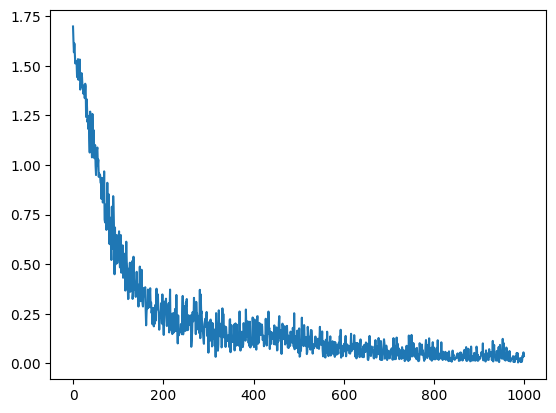

In [17]:
plt.plot(metalosses)

In [18]:
def accuracy(outputs, labels):
  outputs = np.argmax(outputs, axis=1)
  return np.sum(outputs == labels) / float(labels.size)


In [19]:
def evaluate(net,test_classes,task_lr,num_classes=5,num_steps=100,num_eval_updates=3):
  #net.eval()
  losses=[]
  acc_list=[]
  for step in np.arange(num_steps):
    task=TestTask(test_classes,num_classes=5,num_instances=1,num_test_instances=3)
    loaders=get_test_loaders(task)
    trainloader,testloader=loaders["train"],loaders["test"]
    #x_train,y_train=trainloader.__iter__().next()
    data_iterator3 = iter(trainloader)
    x_train, y_train = next(data_iterator3)
    x_train.to(device)
    y_train.to(device)
    #x_test,y_test=testloader.__iter__().next()
    data_iterator4 = iter(testloader)
    x_test, y_test = next(data_iterator4)

    x_train.to(device)
    y_train.to(device)
    x_test.to(device)
    y_test.to(device)
    #def __init__(self,all_classes,num_classes,num_instances,num_test_instances)
    cloned_net=copy.deepcopy(net)
    optim = torch.optim.SGD(cloned_net.parameters(),lr=task_lr)
    for _ in range(num_eval_updates):
      y_train_pred=cloned_net(x_train)
      loss=loss_metric(y_train_pred,y_train)
      optim.zero_grad()
      loss.backward()
      optim.step()
    y_test_pred=cloned_net(x_test)
    loss=loss_metric(y_test_pred,y_test)
    losses.append(loss)
    y_test_pred=y_test_pred.data.cpu().numpy()
    y_test=y_test.data.cpu().numpy()
    #print(y_test)
    #print(y_test_pred)
    acc=accuracy(y_test_pred,y_test)
    acc_list.append(acc)
  return acc_list,losses


In [ ]:
import copy
#test_classes=np.max(testframe['Label'])-np.min(testframe['Label'])
test_classes=list(np.arange(np.min(testframe['Label']),np.max(testframe['Label']+1)))
acc_list,losses=evaluate(net,test_classes,task_lr=1e-1)

In [ ]:
average_test_accuracy=(sum(acc_list)/len(acc_list))

In [ ]:
average_test_accuracy

0.9499999999999994

In [ ]:
import numpy as np
import torch
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(net, test_classes, task_lr, num_classes=5, num_steps=100, num_eval_updates=3, device='cuda'):
    losses = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    net.to(device)  # Ensure the original network is on the correct device

    for step in np.arange(num_steps):
        task = TestTask(test_classes, num_classes=num_classes, num_instances=3, num_test_instances=10)
        loaders = get_test_loaders(task)
        trainloader, testloader = loaders["train"], loaders["test"]

        data_iterator3 = iter(trainloader)
        x_train, y_train = next(data_iterator3)
        x_train, y_train = x_train.to(device), y_train.to(device)

        data_iterator4 = iter(testloader)
        x_test, y_test = next(data_iterator4)
        x_test, y_test = x_test.to(device), y_test.to(device)

        cloned_net = copy.deepcopy(net).to(device)  # Move the cloned network to the correct device
        optim = torch.optim.SGD(cloned_net.parameters(), lr=task_lr)

        for _ in range(num_eval_updates):
            y_train_pred = cloned_net(x_train)
            loss = loss_metric(y_train_pred, y_train)
            optim.zero_grad()
            loss.backward()
            optim.step()

        y_test_pred = cloned_net(x_test)
        loss = loss_metric(y_test_pred, y_test)
        losses.append(loss.item())  # Ensure loss is converted to a scalar

        y_test_pred = torch.argmax(y_test_pred, dim=1).cpu().numpy()
        y_test = y_test.cpu().numpy()

        # Calculate accuracy, precision, recall, and F1 score
        acc = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')

        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return acc_list, precision_list, recall_list, f1_list, losses


In [ ]:
# Assuming 'net' is your model, 'test_classes' are your test classes, and 'device' is either 'cuda' or 'cpu'
acc_list, precision_list, recall_list, f1_list, losses = evaluate(net, test_classes, task_lr=1e-1, device='cuda')

print(f"Accuracy: {np.mean(acc_list)}")
print(f"Precision: {np.mean(precision_list)}")
print(f"Recall: {np.mean(recall_list)}")
print(f"F1 Score: {np.mean(f1_list)}")
print(f"Loss: {np.mean(losses)}")


Accuracy: 0.9452000000000002
Precision: 0.9533615828615831
Recall: 0.9452000000000002
F1 Score: 0.9438663198879164
Loss: 0.16220130637288094
